In [1]:
# Note: the original data in the paper is taken from: https://join.fz-juelich.de/access/
# It operationally hard for us to include the original data in the github
# Therefore, we generate an artificial data that *resembles* on the original data
# The users are encouraged to find and use the orignal data from the above link


# Import Numpy & PyTorch
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

In [2]:
class Snake(nn.Module):#learnable a
  def __init__(self):
      super(Snake, self).__init__()
      self.a = nn.Parameter()
      self.first = True
  def forward(self, x):
    if self.first:
        self.first = False
        a = torch.zeros_like(x[0]).normal_(mean=0,std=50).abs()
        self.a = nn.Parameter(a)
    return (x + (torch.sin(self.a * x) ** 2) / self.a)

In [3]:
class Net(nn.Module):
  # Initialize the layers
  def __init__(self):
      super().__init__()
      self.linear1 = nn.Linear(1, 100)

      self.s1 = Snake() #random a
      self.s2 = Snake() #random a

      self.linear2 = nn.Linear(100, 100)
      self.linear3 = nn.Linear(100, 1)

  # Perform the computation
  def forward(self, x):
      x = self.linear1(x)
      x = self.s1(x)
      x = self.linear2(x)
      x = self.s2(x)
      x = self.linear3(x)
      return x

In [7]:
#define function to call in loop of parameter study
def train(X,Y,Xt,Yt, model):#training data X,Y & test data Xt,Yt

    opt = torch.optim.SGD(model.parameters(), 3e-4, momentum=0.99,weight_decay=3e-3)
    loss_fn = F.mse_loss

    ## in the paper, Epoch=2500
    Epoch = 2500
    
    batch_size = 32
    losses = []
    test_losses = []

    for i in range(Epoch):

      permutation = torch.randperm(X.size()[0])#mini-batch
      for j in range(0,X.size()[0], batch_size):
        indices = permutation[j:j+batch_size]
        batch_x, batch_y = X[indices], Y[indices]

        opt.zero_grad()
        y = model(batch_x)
        loss = loss_fn(y, batch_y) 
        (loss).backward()
        opt.step()
      losses.append(loss)
      with torch.no_grad():
        y = model(Xt)
        loss = loss_fn(y, Yt)
        test_losses.append(loss)
    #    print(loss.item())

    print("Final Loss Training:",losses[Epoch-1])
    print("Final Loss Test:",test_losses[Epoch-1])
    if True:
      plt.figure(figsize=(5, 5))
      plt.xlim=(10)
      plt.plot(range(1, Epoch+1), [loss.detach().numpy() for loss in losses], label='training loss')
      plt.plot([loss.detach().numpy() for loss in test_losses], label='testing loss') 
      plt.legend()
      plt.xlabel('epochs')
      plt.ylabel('loss')
      plt.yscale('log')
      plt.show()

Final Loss Training: tensor(0.0003, grad_fn=<MseLossBackward0>)
Final Loss Test: tensor(0.0015)


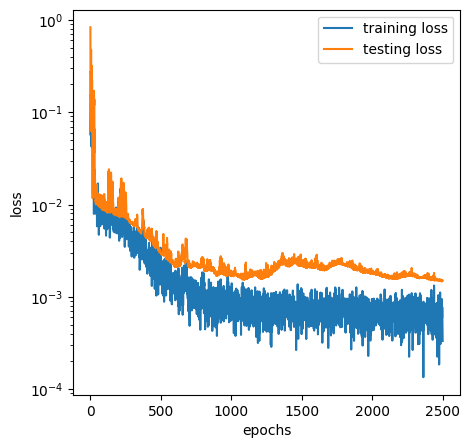

Final Loss Training: tensor(0.0010, grad_fn=<MseLossBackward0>)
Final Loss Test: tensor(0.0021)


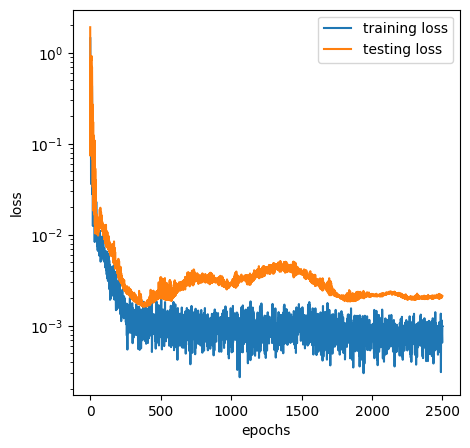

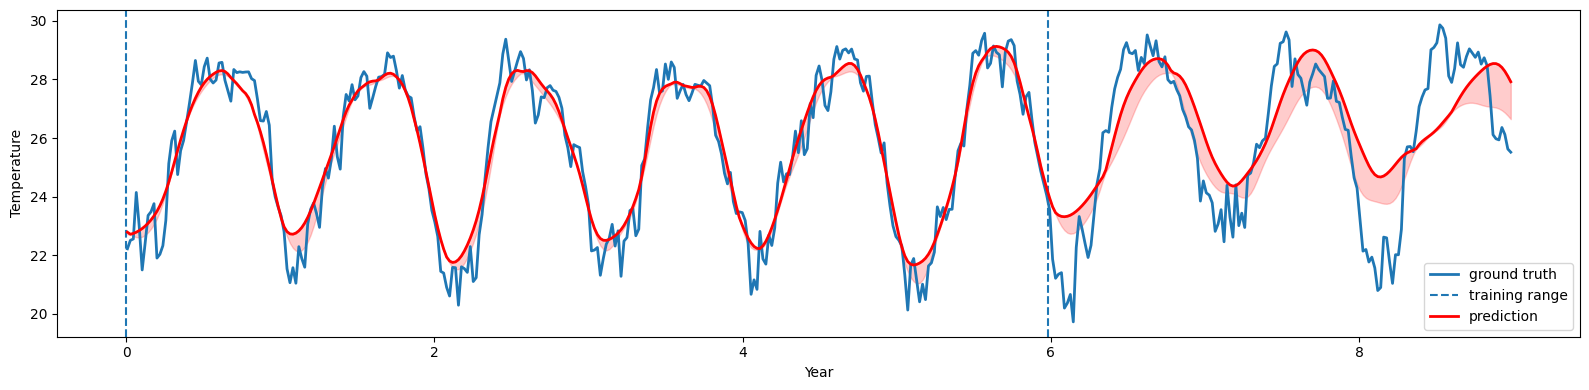

In [8]:
## takes around 10 minutes to finish 2500 epochs 
## maybe it is better to start with setting Epoch=50 and see what happens

torch.manual_seed(1)
AdditionalPlots = False
N_sample = 365*6
N_test = 3287

x_resample = 7
N_realisations = 2

N_test = int(np.floor(N_test/x_resample))
N_sample = int(np.floor(N_sample/x_resample))


#to plot scatter
i_median = int(np.floor(N_realisations/2))
if(N_realisations >= 5):
    i_low = 1
    i_high = N_realisations - 2
else:
    i_low = 0
    i_high = N_realisations - 1
#  print("Representative Indices:",i_low,i_median,i_high)


ystack = np.zeros((N_test,N_realisations))

for j in range(N_realisations):
  DayTemp = pd.read_csv("E2_Data/day_temp_atmospheric.csv")# 3287 lines
  MyTemp = DayTemp.values

#resample
  TempTemp = np.zeros(N_test)
  TempDay = np.zeros(N_test)
  for i in range(N_test):
    TempTemp[i] = np.mean(MyTemp[i*x_resample:(i+1)*x_resample,1])
    TempDay[i] = np.mean(MyTemp[i*x_resample:(i+1)*x_resample,0])


  #normalise
  MeanTemp = np.mean(TempTemp)
#      print("Mean Temperature:",MeanTemp)
  MyTemp1 = TempTemp/MeanTemp
  MyTemp0 = (TempDay/float(365))#/4


  X = torch.tensor(MyTemp0[0:N_sample]).float().unsqueeze(1)
  Y = torch.tensor(MyTemp1[0:N_sample]).float().unsqueeze(1)
  test_X = torch.tensor(MyTemp0[0:N_test]).float().unsqueeze(1)
  test_Y = torch.tensor(MyTemp1[0:N_test]).float().unsqueeze(1)

  if AdditionalPlots:#AdditionalPlots:
    plt.plot(test_X.cpu(), test_Y.cpu(),color='r')
    plt.scatter(X.cpu(), Y.cpu())
    plt.show()
    plt.clf()

  model = Net()
  train(X,Y,test_X,test_Y, model)

  y_pred = model(test_X)#model prediction on uniformly sampled data
  ystack[:,j] = y_pred.cpu().detach().numpy().reshape(N_test)#save for scatter comparison


ystack = np.sort(ystack)# sort along the last axis

plt.figure(figsize=(16, 4))

plt.fill_between(test_X.cpu().detach().numpy().reshape(N_test), MeanTemp*ystack[:,i_low], MeanTemp*ystack[:,i_high], color='r', alpha=0.2)
plt.plot(test_X.cpu().detach().numpy(),MeanTemp*test_Y.cpu().numpy(),label="ground truth",linewidth=2)
plt.axvline(x=0, linestyle='--')
plt.axvline(x=N_sample/365*x_resample, linestyle='--', label='training range')
plt.plot(test_X.cpu().detach().numpy().reshape(N_test),MeanTemp*ystack[:,i_median], color='r',label="prediction",linewidth=2)
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend()
plt.tight_layout()
plt.savefig("Temperature.pdf")
plt.show()